# Taller 6 - Evaluación y selección de modelos

### Autores: [Ivan Meresman](https://ivanlmh.github.io/), [Daniel Herrera-Esposito](https://dherrera1911.github.io/)

## Ejercicio 1 - Metricas de evaluacion para clasificación multiclase

En este taller continuaremos analizando el ejercicio de clasificación de glóbulos blancos del Taller 4. Analizaremos metricas alternativas al accuracy para medir rendimiento, y le aplicaremos pesos a nuestros datos de entrenamiento para balancear las clases en el entrenamiento.

In [31]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import re # Biblioteca para realizar emparejamiento de expresiones regulares (hilos de caracteres)
import os
import sys
import skimage.io as imgio
import skimage as skim
from sklearn.model_selection import train_test_split
from scipy import ndimage as ndi
from sklearn.linear_model import RidgeClassifier

import numpy as np
import numpy.random as rng
import cv2 as c

Primero descargamos las imagenes de las células

In [32]:
%%capture
!wget -O data.zip https://github.com/dherrera1911/talleres_aabc/raw/master/data/blood_images.zip
!unzip data.zip
!wget -qO etiquetas.csv https://raw.githubusercontent.com/dherrera1911/talleres_aabc/master/data/blood_labels.csv

Cargamos los datos a Python:

In [33]:
# Cargar las etiquetas de las imagenes
etiquetas = pd.read_csv("etiquetas.csv")

# Cargar las imagenes
dir_img = 'blood_images'
image_names = sorted([os.path.join(dir_img, f) for f in os.listdir(dir_img) if os.path.isfile(os.path.join(dir_img, f))])
cellImages = np.empty((480, 640, 3, 0), dtype="uint8") #creamos un array vacío para ir llenando con imagenes
for i,fname in enumerate(image_names):
  tmpIm = plt.imread(fname)
  tmpIm = tmpIm.reshape(480, 640, 3, 1)
  cellImages = np.append(cellImages, tmpIm, axis=3)

# Obtenemos las etiquetas del problema
tiposCelulares = etiquetas['Category'].unique()

print(f"El array de datos que contiene las imágenes tiene dimensión {cellImages.shape}")
print(etiquetas)

El array de datos que contiene las imágenes tiene dimensión (480, 640, 3, 347)
     index  Unnamed: 0  Image    Category
0        0         NaN      0  NEUTROPHIL
1        1         NaN      1  NEUTROPHIL
2        2         NaN      2  NEUTROPHIL
3        3         NaN      3  NEUTROPHIL
4        4         NaN      4  NEUTROPHIL
..     ...         ...    ...         ...
342    405         NaN    405  NEUTROPHIL
343    407         NaN    407  NEUTROPHIL
344    408         NaN    408  NEUTROPHIL
345    409         NaN    409  NEUTROPHIL
346    410         NaN    410  EOSINOPHIL

[347 rows x 4 columns]


Aplicamos el procesamiento para genrar imágenes binarias, como en el Taller 4.

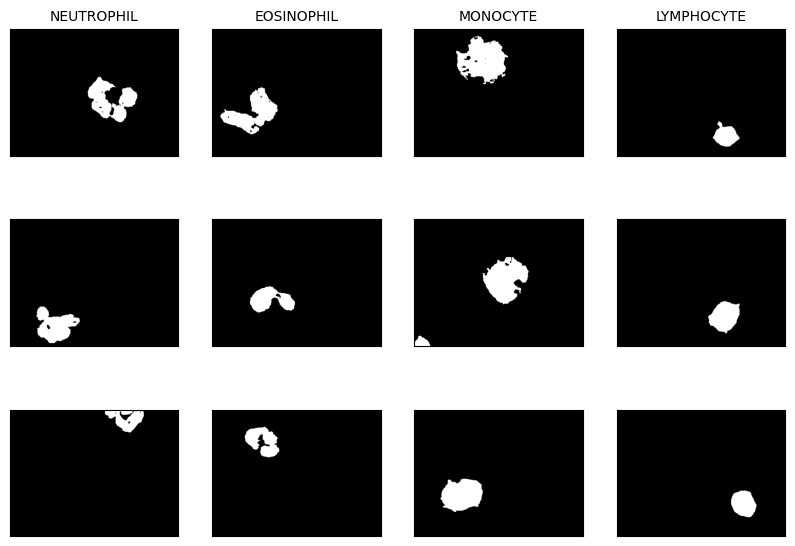

In [7]:
# las imagenes por default se codifican de una forma que solo admite valores entre 0-255.
# Cambiamos eso para hacer la resta del azul y el rojo
cellImages = cellImages.astype("int32")

# tomamos el canal azul (2) y le restamos el canal rojo (0)
cellImages = cellImages[:,:,2,:] - cellImages[:,:,0,:]

# le restamos el valor mínimo para llevar a 0 el valor mínimo, y recodificamos en el formato de las imagenes, uint8
cellImages = cellImages - np.min(cellImages)
cellImages = cellImages.astype("uint8")

# binarizamos las imagenes
cellImages = (cellImages > 130)

# luego aplicamos un poco de procesamiento para eliminar los núcleos de las plaquetas
for im in range(cellImages.shape[2]):
  label_objects, nb_labels = ndi.label(cellImages[:,:,im])
  sizes = np.bincount(label_objects.ravel())
  mask_sizes = sizes > 1000
  mask_sizes[0] = 0
  cellImages[:,:,im] = mask_sizes[label_objects]
    
# graficamos 3 imagenes de cada tipo en la escala de grises
nPlot = 3
plt.figure(figsize=(10,7))
for t in range(len(tiposCelulares)):
    indicesCelula = np.where(etiquetas['Category'] == tiposCelulares[t])[0]
    imagenesTipo = cellImages[:,:,indicesCelula[0:nPlot]]
    for im in range(nPlot):
        plt.subplot(nPlot, len(tiposCelulares), t+1+im*len(tiposCelulares))
        if im==0:
            plt.title(tiposCelulares[t], fontdict={'fontsize': 10})
        plt.imshow(imagenesTipo[:,:,im], cmap='gray')
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
plt.show()

Luego definimos una función para extraer los local binary patterns de las imágenes, que serán los features que usaremos en la clasificación.

In [8]:
from skimage.feature import local_binary_pattern

def extraer_LBP(imagenes, radio, n_puntos):
  nbins = n_puntos+1 # número de patrones posibles
    
  # generamos los nombres de las columnas
  numeroCols = np.arange(nbins).tolist()
  nombresCols = ['LBP'+str(num+1) for num in numeroCols]
    
  # generamos un dataframe vacío para ir llenando con los datos
  lbp = pd.DataFrame([], columns=nombresCols)
    
  for im in range(imagenes.shape[2]):
    # computamos el patrón de cada pixel
    lbp_im = local_binary_pattern(imagenes[:,:,im], P=n_puntos, R=radio, method='uniform')
      
    # extraemos la cantidad de ocurrencias de cada patrón
    histograma, bin_edges = np.histogram(lbp_im, bins=nbins)
      
    # agregamos el histograma de esta imagen como una nueva fila en el dataframe
    histograma = histograma.tolist()
    df_len = len(lbp)
    lbp.loc[df_len] = histograma
  return lbp

Ahora, queremos ver las proporciones de las diferentes clases, para ver si nuestro set de datos está balanceado o no.

**Ejercicio 1:** La línea incompleta de abajo cuenta cuantas ocurrencias de cada clase hay. Complete la línea para obtener las proporciones.

In [9]:
# Extraemos las proporciones de las clases
proporcionesClases = etiquetas['Category'].value_counts() # Completar la línea para calcular proporciones
print(proporcionesClases)

Category
NEUTROPHIL    206
EOSINOPHIL     88
LYMPHOCYTE     33
MONOCYTE       20
Name: count, dtype: int64


Vemos que nuestras clases están bastante desbalanceadas, con la mayoría de las imágenes perteneciendo a la clase NEUTROPHIL, y muy pocas perteneciendo a la clase MONOCYTE. Entrenemos un clasificador como el de Taller 4 sobre estos datos.

Primero separamos las imagenes en set de entrenamiento y testeo, y luego extraemos los local binary patterns de los dos sets de datos (en lbpTrain y lbpTest)

In [10]:
transposedImages = np.transpose(cellImages, (2,1,0))
# separamos en train y test
Xtrain, Xtest, ytrain, ytest = train_test_split(transposedImages, etiquetas['Category'],
                                                test_size=0.20, stratify=etiquetas['Category'], random_state=42)
Xtrain = np.transpose(Xtrain, (2,1,0))
Xtest = np.transpose(Xtest, (2,1,0))

# Extraemos los LBP
radio = 7
n_puntos = radio*8
lbpTrain = extraer_LBP(Xtrain, radio=radio, n_puntos=n_puntos)
lbpTest = extraer_LBP(Xtest, radio=radio, n_puntos=n_puntos)

A continuación entrenamos un clasificador con penalización L2, y lo testeamos en nuestros datos para obtener la accuracy.

In [19]:
alpha = 0.2 # parametro modificable

# Ajustamos y testeamos el modelo con la representacion manual
ridgeBasico = RidgeClassifier(alpha=alpha)
ridgeBasico.fit(lbpTrain, ytrain)
prediccionesTest = ridgeBasico.predict(lbpTest)
scoreBasico = np.sum(prediccionesTest == ytest)/len(ytest)
print(f"La accuracy del modelos básico es: {scoreBasico*100:.1f}%")

La accuracy del modelos básico es: 47.1%


**Ejercicio 2:** ¿Le parece que la accuracy obtenida es buena? Considere que un clasificador aleatorio que asigne una de las 4 clases al azar (elegidas con igual probabilidad) tendría un rendimiento de 25%. Considere también las frecuencias relativas de las clases.

*Inserte su respuesta aquí*

Veamos los resultados de la clasificación de forma más detallada. Abajo graficamos la matriz de confusión del clasificador.

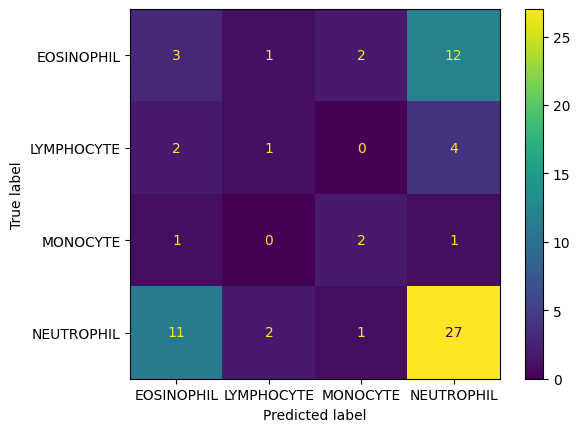

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generamos la matriz de confusion
mConfusionBasico = confusion_matrix(y_true=ytest, y_pred=prediccionesTest)

# Y luego la visualizamos
mcPlot = ConfusionMatrixDisplay(confusion_matrix=mConfusionBasico, display_labels=ridgeBasico.classes_)
mcPlot.plot()
plt.show()

**Ejercicio 3:** ¿Qué interpretación hace sobre el comportamiento del clasificador a partir de la matriz de confusión?

*Inserte su respuesta aquí*

Para obtener una evaluación más cuantitativa de los resultados, extraeremos las métricas de rendimiento para clasificadores: la precisión, el recall y el f1-score. Abajo, los *macro avg* muestran el promedio de estas cantidades entre las clases, y el *micro avg* el promedio pesando a cada clase según la cantidad de ejemplos que tiene.

In [21]:
from sklearn.metrics import classification_report

print(classification_report(ytest, prediccionesTest))

              precision    recall  f1-score   support

  EOSINOPHIL       0.18      0.17      0.17        18
  LYMPHOCYTE       0.25      0.14      0.18         7
    MONOCYTE       0.40      0.50      0.44         4
  NEUTROPHIL       0.61      0.66      0.64        41

    accuracy                           0.47        70
   macro avg       0.36      0.37      0.36        70
weighted avg       0.45      0.47      0.46        70



**Ejercicio 4:** Discuta brevemente los resultados que se observan en la tabla, y su relación con la matriz de confusión.

*Inserte su respuesta aquí*

A continuación, entrenaremos un nuevo modelo, pero aplicándole pesos a los datos de entrenamiento, de forma que cada clase tenga el mismo peso total. Para ello a cada dato le aplicamos un peso igual al inverso de la frecuencia de su clase.

In [22]:
# Primero obtenemos el peso de cada clase, tomando el inverso de su frecuencia
pesosClases = 1/proporcionesClases
print("Los pesos de cada clase son:")
print(pesosClases, "\n")
# Luego generamos el vector, extrayendo el peso de cada ejemplo usando el nombre de la clase
pesosTrain = pesosClases[ytrain]
print("Los primeros 10 elementos del vector de pesos generados son:")
print(pesosTrain[1:10])

Los pesos de cada clase son:
Category
NEUTROPHIL    0.004854
EOSINOPHIL    0.011364
LYMPHOCYTE    0.030303
MONOCYTE      0.050000
Name: count, dtype: float64 

Los primeros 10 elementos del vector de pesos generados son:
Category
NEUTROPHIL    0.004854
NEUTROPHIL    0.004854
NEUTROPHIL    0.004854
MONOCYTE      0.050000
LYMPHOCYTE    0.030303
NEUTROPHIL    0.004854
NEUTROPHIL    0.004854
EOSINOPHIL    0.011364
NEUTROPHIL    0.004854
Name: count, dtype: float64


In [23]:
# Luego entrenamos un nuevo clasificador logístico con regularización L2, usando los pesos
alpha = 0.1
ridgePesos = RidgeClassifier(alpha=alpha)
ridgePesos.fit(lbpTrain, ytrain, sample_weight=pesosTrain) # A la función fit le agregamos el parámetro de los pesos
prediccionesPesos = ridgePesos.predict(lbpTest)
scorePesos = np.sum(prediccionesPesos == ytest)/len(ytest)
print(f"La accuracy del modelos con clases balanceadas es: {scorePesos*100:.1f}% \n")

La accuracy del modelos con clases balanceadas es: 40.0% 



**Ejercicio 5:** Grafique la matriz de confusion del nuevo modelo, e imprima las medidas de rendimiento de clasificación.

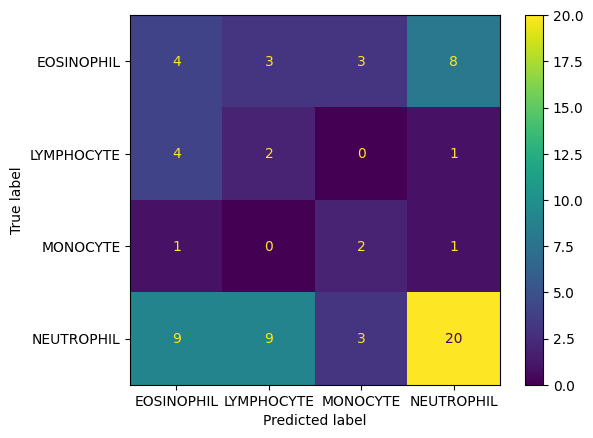

In [24]:
# Generamos la matriz de confusion
mConfusionPesos = confusion_matrix(y_true=ytest, y_pred=prediccionesPesos)
# Y luego la visualizamos
mcPlot = ConfusionMatrixDisplay(confusion_matrix=mConfusionPesos, display_labels=ridgePesos.classes_)
mcPlot.plot()
plt.show()
# Inserte su codigo aqui

**Ejercicio 6:** Discuta brevemente las diferencias de comportamiento de este nuevo modelo con respecto al modelo anterior, y cómo se ven reflejados en la matriz de confusion y en las métricas de rendimiento. ¿Cree que se puede decir que el modelo entrenado con pesos es mejor? Justifique.

*Inserte su respuesta aquí*

**Ejercicio extra:** A veces los diferentes errores que puede cometer un modelo tienen diferente costo. Por ejemplo, si un modelo se usa para diagnosticar cáncer y determinar si a un paciente se le da el alta o si se le hacen más estudios, es más costoso darle el alta erroneamente a un paciente con cáncer que pedirle más estudios a un paciente sano.

Supongamos que en nuestro problema es importante clasificar correctamente a las células de clase LYMPHOCYTE. Proponga una forma de aumentar el rendimiento para esta clase en el modelo, usando las herramientas vistas arriba. Implemente el nuevo modelo, visualice la matriz de confusión e imprima las medidas de rendimiento.

**Pista:** Le puede ser útil modificar los pesos de las clases utilizados en el ejemplo anterior.

## Ejercicio 2 - Cross Validation y Seleccion de parametros

### Ejercicio 2.1 - K-Fold CV

Vamos a ver un poco los ejercicios del taller 5 y reevaluar algunos resultados obtenidos.

Imaginemos que nos piden que entrenemos el mejor modelo posible para clasificacion de imagenes de hojas con los datos que tenemos (y sin augmentarlos), y nos preguntan que accuracy estimamos que va a tener el modelo sobre nuevas imagenes que van a ser recolectadas y preprocesadas de la misma manera que las de entrenamiento.

**Pregunta 1:**
¿Sería la estimación de accuracy del modelo obtenida en el taller 5 sobre un sub-set de validacion la mejor estimación de accuracy?


**Pregunta 2:**
El modelo entrenado como en el taller 5, sobre un sub-set de entrenamiento ¿sería el mejor modelo que le podemos proveer?

*Puede responder aqui*

Para mejorar los dos puntos anteriores, podemos evaluar nuestro modelo con k-folds cross validation, sobre el dataset entero.

In [34]:
# Paquete para redimensionar las imagenes sin deformarlas
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation, Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization

Cargamos los datos como el el cuaderno 5

In [36]:
%%capture
!wget -O train.csv https://raw.githubusercontent.com/dherrera1911/talleres_aabc/master/data/leaves_train.csv
!wget -O leaves_images.zip https://github.com/dherrera1911/talleres_aabc/raw/master/data/leaves_images.zip
!unzip leaves_images.zip

In [37]:
train = pd.read_csv('./train.csv')
# Los datos de margen, forma y textura seran nuestra entrada
x = train.drop(['species','id'],axis=1)
# La especie nuestra salida, lo que queremos predecir
y = train['species']
# id de la imagen a la que corresponden los datos
ids = train['id']

img_path = './images/'

# Generaremos imagenes cuadradas de tamaño fijo
# con la imagen de la hoja centrada y a escala
size=200
data = []
for ID in ids:
    img = Image.open(img_path+str(ID)+".jpg")
    img.thumbnail((size,size))
    img_nueva = Image.new("1", (size,size), 0)
    img_nueva.paste(img, ( int((size - img.size[0]) / 2), int((size - img.size[1]) / 2) ))
    data.append(img_to_array(img_nueva))
np.array(data).shape

(990, 200, 200, 1)

In [38]:
x = np.array(data)
y = LabelEncoder().fit(y).transform(y)
y_cat = to_categorical(y)
x_train , x_test , y_train_cat , y_test_cat = train_test_split(x, y , test_size = 0.25 , random_state = 42)

**Ejercicio 1:**
Entrenen su modelo una vez sobre los datos particionados para luego poder comparar.

In [39]:
# Busquen un modelo que les haya traido resultados buenos
# pero tal vez no el que les llevo una hora de entrenamiento.
# Recuerden que el K-folds CV va a entrenar muchas veces.

Probemos analizar el rendimiento de un modelo sobre K particiones (folds) con el algoritmo K-folds.

*Recordatorio del algoritmo:* divide lo que definamos como set de entrenamiento en K partes, y entrena K veces el modelo (siempre desde cero) sobre todas las particiones menos una, y la que se deja afuera se usa para evaluar (set de validacion).

**Ejercicio 2:** El codigo de abajo lo implementa con un modelo de ejemplo, prueben con el suyo!

In [40]:
from sklearn.model_selection import KFold

num_particiones=4

# Define el iterador K-fold Cross Validator
kfold = KFold(n_splits=num_particiones, shuffle=True)

# Define listas para guardar los resultados sobre cada particion
acc_por_particion = []
loss_por_particion = []

# Evaluacion del modelo usando K-fold Cross Validation
particion_num = 1
for train, test in kfold.split(x,y_cat):

  # Define la arquitectura del modelo
  model = Sequential()
  model.add(Input(shape=(200,200,1)))
  model.add(Conv2D(32, (5,5)))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(32, (5,5)))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(16, (3,3)))
  model.add(MaxPooling2D((2,2)))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Dropout(0.3))
  model.add(Activation('sigmoid'))
  model.add(Dense(99))
  model.add(Activation('softmax'))

  # Compila el modelo
  model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=["accuracy"])

  # Imprime entrenamiento para la particion
  print('------------------------------------------------------------------------')
  print(f'Entrenando la partición numero {particion_num}...')

  # Ajuste del modelo a los datos de la particion
  history = model.fit(x[train], y_cat[train],
              batch_size=32,
              epochs=20,
              verbose=1)

  # Imprimir y guardar los puntajes sobre la particion de testeo
  scores = model.evaluate(x[test], y_cat[test], verbose=0)
  print(f'Score for fold {particion_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_por_particion.append(scores[1] * 100)
  loss_por_particion.append(scores[0])

  # Aumentar el numero de particion
  particion_num = particion_num + 1

------------------------------------------------------------------------
Entrenando la partición numero 1...
Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.0368 - loss: 4.6940
Epoch 2/20
13/24 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.2981 - loss: 3.3102

KeyboardInterrupt: 

In [ ]:
# Puntaje promedio
print('Puntaje por partición')
for i in range(0, len(acc_por_particion)):
  print(f'> Partición {i+1} - Loss: {loss_por_particion[i]} - Accuracy: {acc_por_particion[i]}%')
print('------------------------------------------------------------------------')
print('Rendimiento promedio para todas las particiones:')
print(f'> Accuracy: {np.mean(acc_por_particion)} (+- {np.std(acc_por_particion)})')
print(f'> Loss: {np.mean(loss_por_particion)}')

Como pueden ver, en cierta forma esto nos da mas informacion sobre los datos.

**Pregunta 3:** ¿Que concluyen de la variacion del accuracy para cada partición?


**Pregunta 4:** ¿Tiene sentido hacer CV sobre el modelo con las capas que augmentan los datos?

*Pueden responder aqui*

## Ejercicio 2.2 - Grid Search de parametros con Cross Validation

A lo largo de casi todos los ejercicios de los talleres, les hemos pedido que implementen algoritmos y modelos que muchas veces dependen de parametros definidos por el usuario. Casi siempre les proponiamos como ejercicio o experimento, que modificaran estos valores y vieran como variaban los resultados.

Como vimos la clase pasado, hay formas de implementar busquedas de combinaciones de parametros que automaticen y hagan de esta decision (el valor del parametro) algo un poco menos aleatorio.

Sklearn tiene una funcion para implementar un grid search, donde se define el clasificador que se utilizara y un array de valores que queremos que tome uno o varios parametros.

A modo de ejemplo usaremos los datos precalculados de las hojas. Elegimos estos datos (que son bastante livianos) ya que el grid search puede ser una tarea lenta (se prueban todas las combinaciones de parametros y se hace cross validation sobre todas) y no queremos que se pasen el resto del taller mirando la pantalla.

Recuerden que ya con un clasificador Random Forest y con una red neuronal simple, habiamos obtenido muy buenos resultados sobre estos datos! Ahora el desafio esta en mover el accuracy de test un poquito mas cerca de 100%.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
train = pd.read_csv('./train.csv')

# Los datos de margen, forma y textura seran nuestra entrada
x = train.drop(['species','id'],axis=1)

x = StandardScaler().fit(x).transform(x)
print(x.shape, x.mean(), x.std())

y = train['species']
y = LabelEncoder().fit(y).transform(y)
ids = train['id']

# Separamos los datos en un conjunto de entrenamiento y otro de prueba
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.25 , random_state = 42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(x_train , y_train)

In [ ]:
print(classifier.score(x_test, y_test))

**Ejercicio 1:** Intenten mejorar el resultado optimizando los parametros con un grid search.

Conviene comenzar creando una grilla de parametros a probar a partir de valores por default o que fueron probados y tienen sentido. Recuerden consultar la documentacion de sklearn en caso de no recordar que hace algun parametro!

In [ ]:
from sklearn.model_selection import GridSearchCV
# Definir grilla
param_grid = {
    'max_depth': [90, 100, 110],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [ ]:
# Crear un modelo
rf = RandomForestClassifier()
# Crear un modelo de Grid Search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)
grid_result = grid_search.fit(x_train, y_train)

Veamos cual es la combinacion optima de paramtros y que rendimiento tienen.

El CV en "GridSearchCV" hace referencia a que los valores de accuracy son obtenidos con cross validation, por lo cual son una buena estimacion, pero debemos guardar un set de testeo, ya que los datos de validacion estaran siendo utilizados para elegir los parametros y por lo tanto dejan de ser desconocidos para el modelo.

In [ ]:
print( "Mejores Parametros:")
print(grid_search.best_params_)

print()
mejor_modelo = grid_search.best_estimator_

print('Rendimiento del mejor modelo:')
print('Accuracy = {:0.2f}%.'.format(100*mejor_modelo.score(x_test, y_test)))


Antes de terminar probemos hacer esto con un modelo de Keras. Tiene una pequena vuelta (hay que usar un wrapper de sklearn para keras) pero es algo que sera muy util.

En el ejemplo a continuacion variamos la cantidad de Neuronas de una capa de una red neuronal, y la funcion de optimizacion del entrenamiento (entre 4 funciones muy populares).

**Ejercicio 2:** Prueben agregar mas capas o hacer el grid search para otro valor, como el dropout o el batch size.

In [ ]:
y_train_cat = to_categorical(y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Debemos definir una funcion que cree el modelo
# esto ser'a lo que le pasemos a la funcion KerasClassifier
def crear_modelo(optimizer='adam', neuronas=512):
  # crear el modelo
  model = Sequential()
  model.add(Dense(neuronas,input_dim=192))
  model.add(Dropout(0.2))
  model.add(Activation('sigmoid'))
  model.add(Dense(99))
  model.add(Activation('softmax'))
  # Compila el modelo
  model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=["accuracy"])
  return model


# fijar la random seed para reproducibilidad
seed = 42
np.random.seed(seed)

# crear modelo con el "envoltorio" KerasClassifier
model = KerasClassifier(build_fn=crear_modelo, epochs=40, batch_size=32, verbose=1)

# definir parametros para el grid search:
# Estas siete funciones son algunas de las mas populares,
# alguna son mas recientes y otras forman parte de la historia de las redes neuronales
# la documentacion de Keras tiene explicaciones cortas y claras, pero se puede encontrar
# muy buen material al respecto por ah'i
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adam']
neuronas = [256, 512, 1024]
param_grid = dict(optimizer=optimizer, neuronas=neuronas)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train_cat)

# resumen de los resultados
print("Mejor accuracy: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) con: %r" % (mean, stdev, param))

Comenten las opciones que probaron y como obtuvieron los mejores resultados.